# Soluciones

### Solución 1

In [1]:
f <- function(x,m=0,s=1){
    H<-function(t) 1-pnorm(t,m,s)
        integral<-integrate(H,lower=x,upper=Inf)$value
        res<-H(x)/integral
        return(res)
}
f(x <- 0:1) # el primer argumento de f no es un vector

Warning message in if (is.finite(lower)) {:
“la condición tiene longitud > 1 y sólo el primer elemento será usado”

[1] 1.2533141 0.3976897

In [2]:
# Vectorizemos la función para calcular [f(xi)] para algun xi

Vectorize(f)(x)

[1] 1.253314 1.904271

In [3]:
y <- rep(NA,2)
x <- 0:1
for(i in 1:2) y[i] <- f(x[i])
y

[1] 1.253314 1.904271

In [4]:
# Usamos sapply

y <- sapply(x,"f")
y

[1] 1.253314 1.904271

In [5]:
# Calculemos las probabilidades binomiales. Respuesta dada por Josias Ruegg Yupa

binomial.pmf <- function(x, k, p) {
    if(x == 0) {
        return ((1 - p) ** k)
  }
  return (((k - x + 1) * p)/(x * (1 - p)) * binomial.pmf(x - 1, k, p))
}

# Pruebas 

valores_prueba <- lapply(1:100, function(x) {c(sample(10, 1), sample(10, 1), runif(1, 0, 1))})

binomial.pmf.resultados <- sapply(valores_prueba, function(test.param) {binomial.pmf(test.param[1], test.param[2], test.param[3])})

dbinom.resultados <- sapply(valores_prueba, function(test.param) {dbinom(test.param[1], test.param[2], test.param[3])})

all.equal(binomial.pmf.resultados, dbinom.resultados)

[1] TRUE

Respuesta alterativa:

In [6]:
# Prueba
binomial.pmf(x = 15, k = 32, p = 0.35)
dbinom(15, 32, 0.35)

[1] 0.05409428

[1] 0.05409428

inf,sup,frec,prob
1.000000,1.000333,50,0.016666667
1.000333,1.000666,19,0.006333333
1.000666,1.001000,21,0.007000000
1.001000,1.001333,21,0.007000000
1.001333,1.001666,18,0.006000000
1.001666,1.001999,14,0.004666667


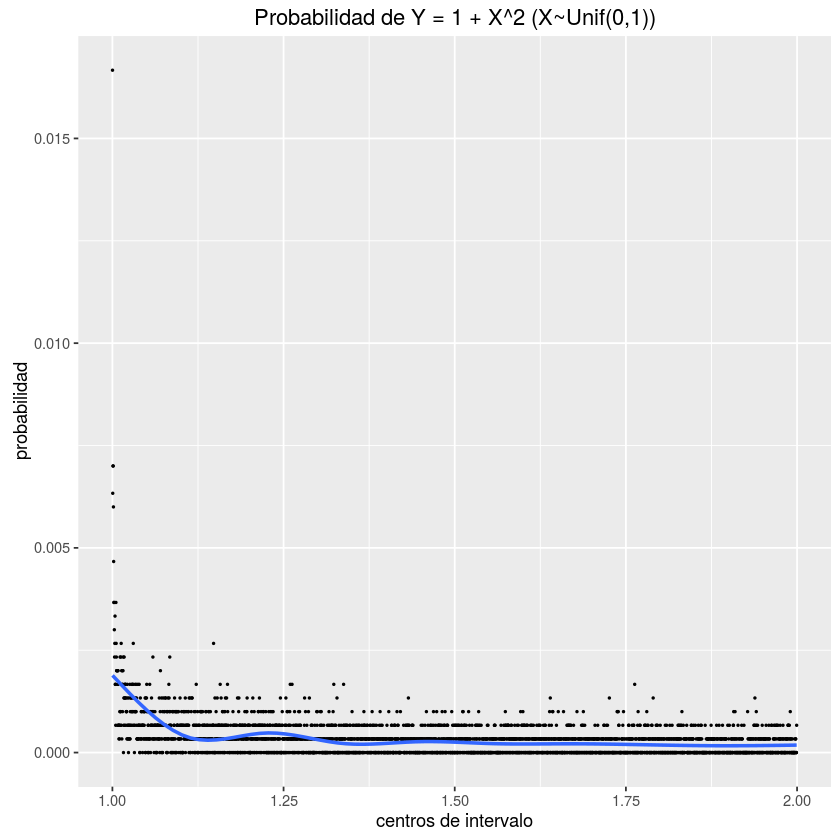

In [7]:
# Problema de simulacion : Respuesta dada por Luis Vasquez Espinoza.

library("ggplot2")
simulate.y <- function(n){
  return(1 + runif(n)^2)
}

intervalo <- function(value, min, max, total_intervalos){
  i <- 1
  intervalo_longitud <- (max-min)/total_intervalos 
  a <- min
  b <- min + intervalo_longitud
  while(i < total_intervalos){
    if(a <= value && value < b){
      return (i)
    }
    i <- i + 1
    a <- b
    b <- a + intervalo_longitud
  }
  
  if(a <= value && value <= max){
    return(i)
  } else {
    print("Valor no clasificado en un intervalo")
    return(-1)
  }
}

frecuencia <- function(values, min, max){
    n <- length(values)
  longitud_intervalo <- (max - min)/n
  cotas_inf <- c() # vector de los valores inferiores de cada intervalo
  cotas_sup <- c() # vector de los valores superiores de cada intervalo
  for(i in 1:n){
    cotas_inf[i] <- min + (i - 1)*longitud_intervalo
    cotas_sup[i] <- cotas_inf[i] + longitud_intervalo
  }
  df <- data.frame("inf" = cotas_inf, "sup" = cotas_sup)
  
  frecuencia_vector <- rep(0, n) # Vector de frecuencias
  for(i in 1:n){
    indice <- intervalo(value = values[i], min = min, max = max, total_intervalos = n)
    frecuencia_vector[indice] <- frecuencia_vector[indice] + 1
  }
  df$frec <- frecuencia_vector
  df$prob <- df$frec/n
  return(df)
}

# Experimentando valores
n <- 3000

y <- simulate.y(n)
df <- frecuencia(values = y, min = min(y), max = max(y))
head(df)
plot <- ggplot(data = df, mapping = aes(x = (sup + inf)/2, y = prob)) + geom_point(size = 0.3) + geom_smooth(se = F)
plot <- plot + xlab(label = "centros de intervalo") + ylab(label = "probabilidad") + ggtitle("Probabilidad de Y = 1 + X^2 (X~Unif(0,1))")
plot

### Solución 2

Basicamente el problema propone buscar la probabilidad de darle una cantidad de caramelos par al grupo de hombres; como para cada una de las personas darles un caramelo sería equiprobable, entonces podemos simplemente verificar dos cantidades MT y WT, las cuales serían la cantidad de caramelos dados a los hombres y mujeres respectivamente. En estas instancias solo debemos fijarnos en la probabilidad de darle un caramelo a un hombre (en cuyo caso aporta a MT) y luego hallar todos los casos en los cuales $MT\,mod\,2 = 0$.

Para asegurarnos de la condición final, basta plantear una tabla y una recursión para una cantidad arbitraria de MT y WT, y solo iterar por los valores posibles de MT que sean pares.

La recursión es sencilla, en efecto se puede escribir,

$$
    P(MT,WT) = \left\{
        \begin{array}{cc}
            &1 &MT==0\,\wedge\,WT==0 \\
            &(1-p)^{WT} &MT==0 \\
            &p^{MT} &WT==0 \\
            &p\cdot P(MT-1,WT) + (1-p)\cdot P(MT,WT-1) & En\,otro\,caso
        \end{array}
    \right.$$
    
Para hallar la respuesta, inicializariamos una variable $Respuesta = 0$ y sumamos las probabilidades para $MT=0,2,..,C-C\,mod\,2$.

In [8]:
# Respuesta dada por Victor Galvan Loyola

Hombre <- 10
Mujer <- 20
Caramelos <- 7
p <- Hombre/(Hombre+Mujer)
tabla <- matrix(0,nrow = Caramelos,ncol= Caramelos) # Tabla para el DP
vis <- matrix(F,nrow = Caramelos,ncol=Caramelos) # Tabla de estado visitado para el DP

dp <- function(hombre,mujer){ # Tabla de DP
    if(hombre == 0 && mujer == 0){
        return(1.0) # Valor por defecto. Neutro de multiplicacion
    }
    if(hombre == 0){
        return ((1-p)**(mujer)) # Solo queda darle caramelos a mujeres
    }
    if(mujer == 0){
        return (p**(hombre)) # Solo queda darle caramelos a hombres
    }
    if(vis[hombre,mujer]) return (tabla[hombre,mujer]) # Estado visitado, devolvemos la respuesta
    res <- p*dp(hombre-1,mujer) + (1-p)*dp(hombre,mujer-1) # Recursion planteada
    vis[hombre,mujer] = T # Declaramos que el estado fue visitado
    tabla[hombre,mujer] = res # Almacenamos la respuesta
    return(res)
}
    
respuesta = 0 # Inicializamos la respuesta a 0
i = 0 # Inicializamos un iterador a 0 (menor valor par posible)
while(i <= Caramelos ){
    respuesta = respuesta + dp(i,Caramelos-i) # Fijamos el valor MT como un valor par y probamos la probabilidad
    i <- i+2
}

cat(sprintf(c("Probabilidad de darle caramelo a un hombre=%.7f", "Probabilidad Total=%.7f"), c(p,respuesta)), sep=" ")

Probabilidad de darle caramelo a un hombre=0.3333333 Probabilidad Total=0.5002286

El siguiente problema se puede ver desde el punto de vista de combinatoria y desarrollar un algoritmo de una complejidad considerable, pero si nos fijamos bien en las condiciones, podemos plantear lo siguiente:

Asumamos que ya tenemos una bandera válida de longitud $n$ que termine en color blanco, denotada por F(n,0). Asumiendo que Blanco=0, Rojo=1 y Azul=2. Como una franja de color blanco puede ir después de una de color rojo, entonces al valor de F(n,0) aporta F(n-1,1). Además de ello, también está la opción de que el color de la anterior franja sea de color azul, pero en tal caso es necesario que su precedente sea de color rojo.
Como el color azul es fijo, entonces a este valor aporta F(n-2,1), por lo que,
$$ F(n,0) = F(n-1,1) + F(n-2,1) $$

Además, es sencillo notar que el color blanco y el rojo son simétricos, por lo que se da que

$$ F(n,1) = F(n-1,0) + F(n-2,0) $$

Lo que implica que la cantidad total para una longitud $N$ sería

$$ F(N) = 2\cdot \left(fib(N-1) + fib(N-2)\right) $$
Donde $fib$ es la serie de Fibonacci.

Algo equivalente es tener que F(N) = F(N-1) + F(N-2) pero con F(1) = 2 y F(2) = 2 como valores iniciales.

In [9]:
# Respuesta dada por Victor Galvan Loyola

N <- 5 
F <- rep(0,N+1) # Creamos un vector para almacenar los elementos (para evitar la alta complejidad de la recursión de Fibonacci)
F[1] = 2 # Inicializamos el primer elemento
F[2] = 2 # Inicializamos el segundo elemento
i <- 3 # Inicializamos el iterador para hallar la respuesta
while(i <= N){
    F[i] = F[i-1] + F[i-2] # Formula planteada como Fibonacci
    i <- i+1
}
sprintf(c("%d"),c(F[N]))

[1] "10"

### Solucion 3

In [10]:
dientes.df <- read.table("dientes.txt", header = T)
edad.df <- read.table("edad.txt", header = T)
concatenacion.df <- merge(edad.df, dientes.df) 
resultado <- as.list(concatenacion.df) 
concatenacion.df 
resultado # Ver como lista


ID,Edad,Num_dientes
1,18,28
2,19,27
3,17,32
4,18,28
5,22,26
6,17,28
7,17,28
8,31,32
9,19,28
10,18,28


$ID
 [1]  1  2  3  4  5  6  7  8  9 10

$Edad
 [1] 18 19 17 18 22 17 17 31 19 18

$Num_dientes
 [1] 28 27 32 28 26 28 28 32 28 28

In [11]:
orden2 <- order(concatenacion.df[2])
resultado_2 <- concatenacion.df[orden2,]
resultado_2

,ID,Edad,Num_dientes
3,3,17,32
6,6,17,28
7,7,17,28
1,1,18,28
4,4,18,28
10,10,18,28
2,2,19,27
9,9,19,28
5,5,22,26
8,8,31,32


### Solución 4


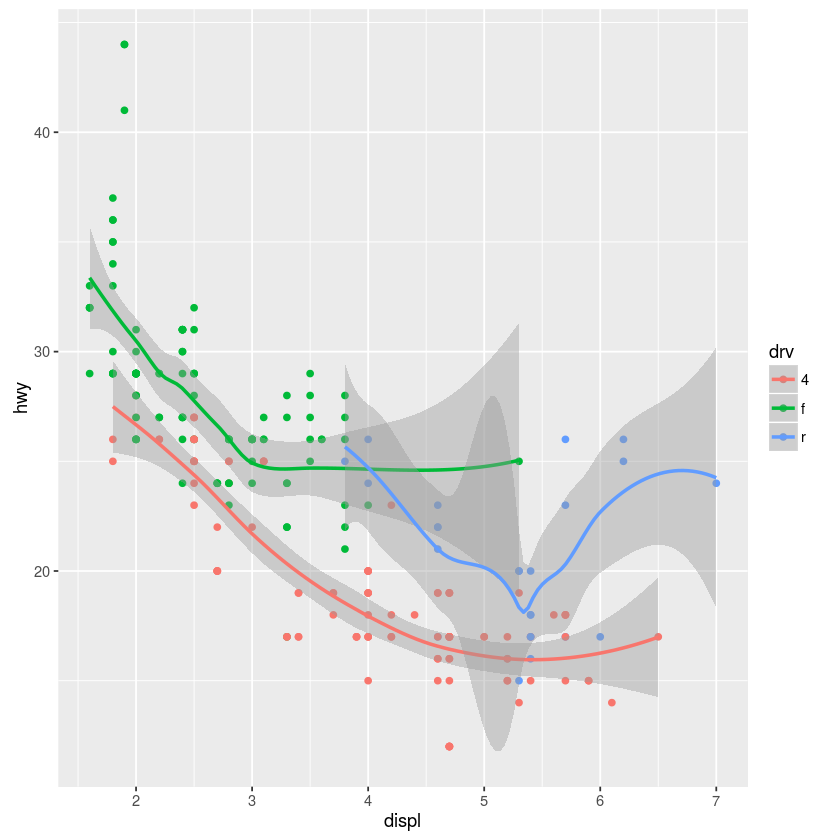

In [12]:
library("ggplot2")
ggplot(data = mpg, mapping = aes(x = displ, y = hwy, color = drv)) + 
geom_point() + 
geom_smooth(se = TRUE)

Respuestas: Añade bandas de error estándar a las líneas.  Por defecto `se =TRUE`

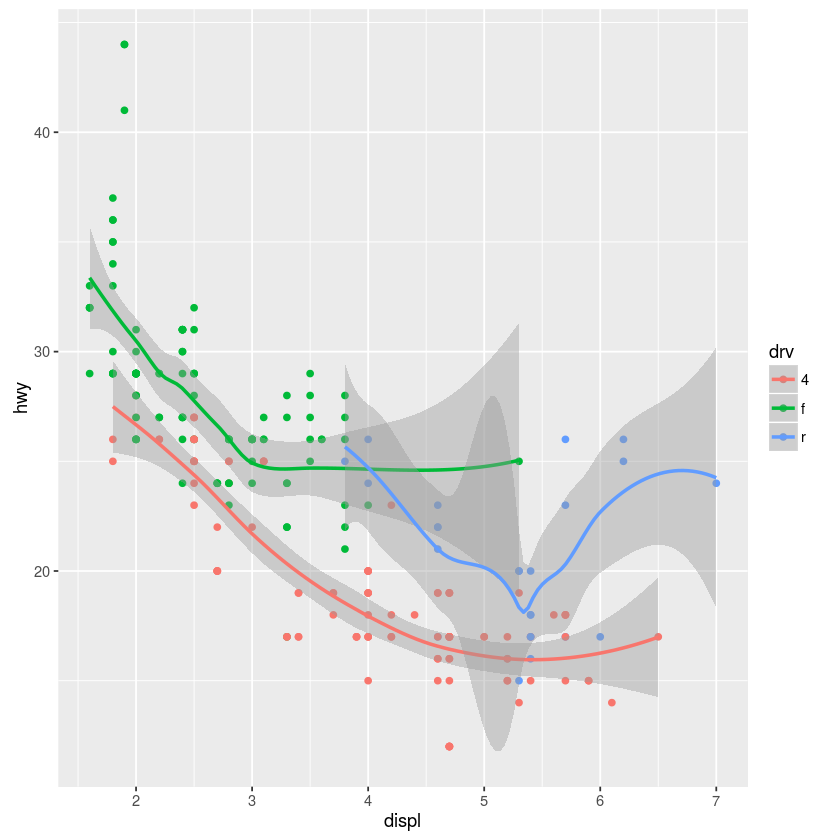

In [13]:
ggplot(data = mpg, mapping = aes(x = displ, y = hwy, color = drv)) + 
geom_point() + geom_smooth()

Respuesta: El `geom` predeterminado para [stat_summary](http://ggplot2.tidyverse.org/reference/stat_summary.html) es el argumento  `geom_pointrange`.  Pero el `stat` por defecto para [geom_pointrange](http://ggplot2.tidyverse.org/reference/geom_linerange.html) es `identity`, así usamos `geom_pointrange(stat = "summary")`.

No summary function supplied, defaulting to `mean_se()


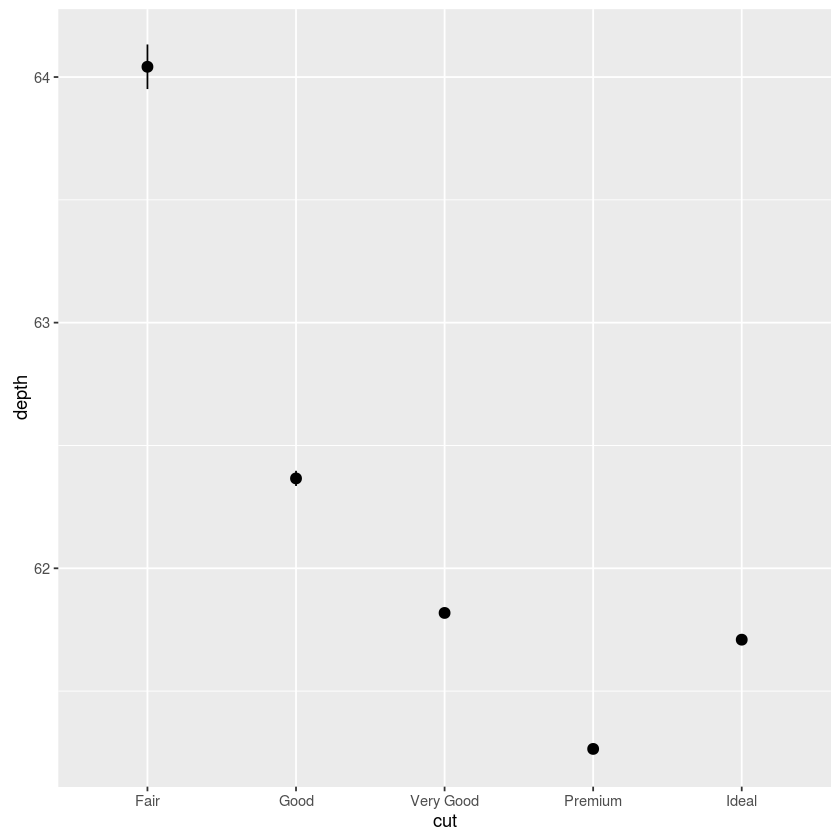

In [14]:
ggplot(data = diamonds) + 
 geom_pointrange(mapping = aes(x = cut, y = depth), stat = "summary",
  )

El mensaje predeterminado dice que `stat_summary` utiliza `mean` y `sd` para calcular el punto y el rango de la línea. Así que vamos a usar los valores anteriores de `fun.ymin, fun.ymax` y `fun.y`:

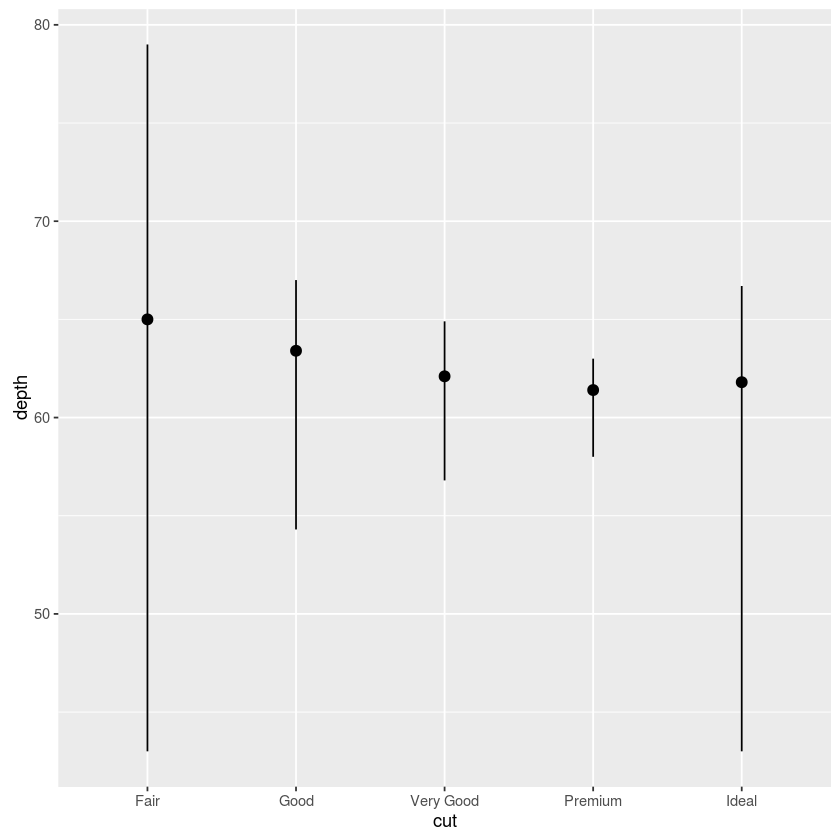

In [15]:
ggplot(data = diamonds) + 
  geom_pointrange(
    mapping = aes(x = cut, y = depth),
    stat = "summary",
    fun.ymin = min,
    fun.ymax = max,
    fun.y = median
  )

Respuesta: `geom_col` difiere de `geom_bar` en su `stat` por defecto. `geom_col` utiliza el  `stat`, `identity`. Por lo tanto, se espera que ya exista una variable para la altura de las barras. `geom_bar` utiliza el `stat`, `count`, y por lo tanto contará las observaciones en grupos para generar la variable a utilizar para la altura de las barras.

Respuesta :`stat_smooth` calcula:

* `y`, valor a predecir.
* `ymin`, valor inferior del intervalo de confianza.
* `ymax`, valor superior del intervalo de confianza.
* `se` error estándar.

Hay parámetros como `method` que determina qué método se utiliza para calcular las predicciones y el intervalo de confianza y algunos otros argumentos que se pasan a este paramétro.

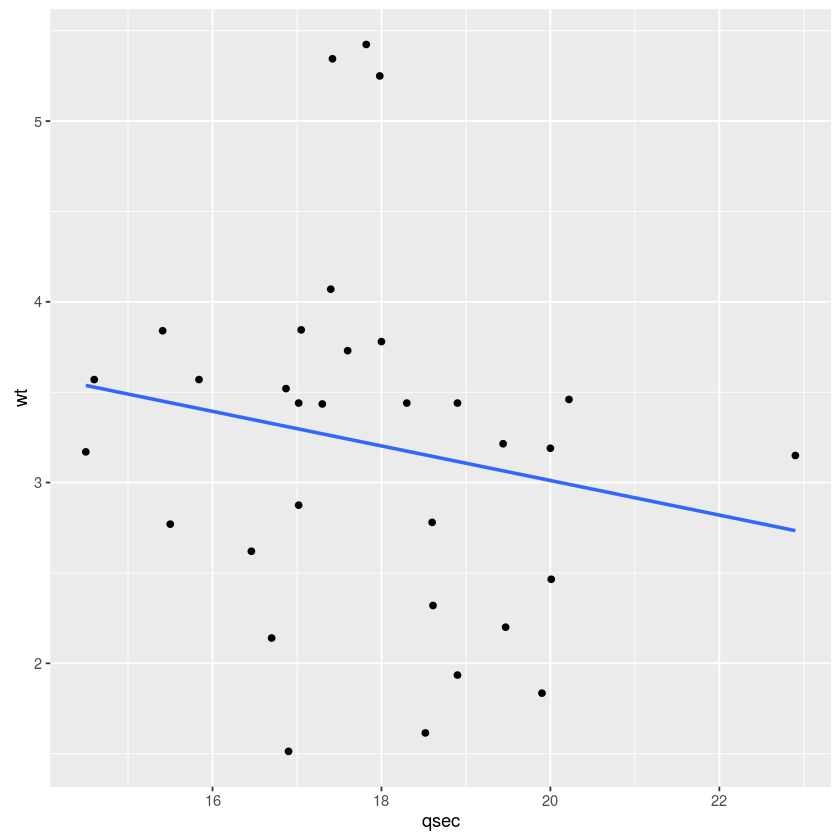

In [16]:
# method lm
g <- ggplot(mtcars, aes(qsec, wt))
g + stat_smooth(method = "lm", se =FALSE) + geom_point()

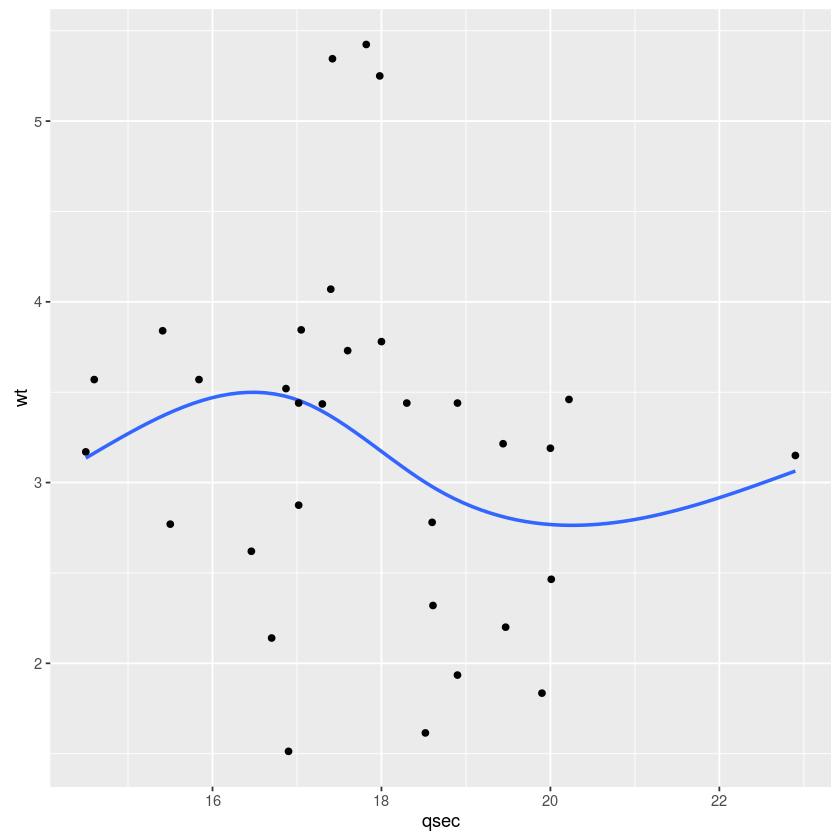

In [17]:
# Metodo rlm
library(splines)
library(MASS)

g <- ggplot(mtcars, aes(qsec, wt))
g + stat_smooth(method = "rlm", formula= y ~ ns(x,3), se = FALSE) + geom_point()


No. Debido a que `geom_point` y `geom_smooth` utilizan los mismos datos y asignaciones. Ellos heredarán esas opciones del objeto `ggplot`, y por lo tanto no es necesario especificar de nuevo (o dos veces).

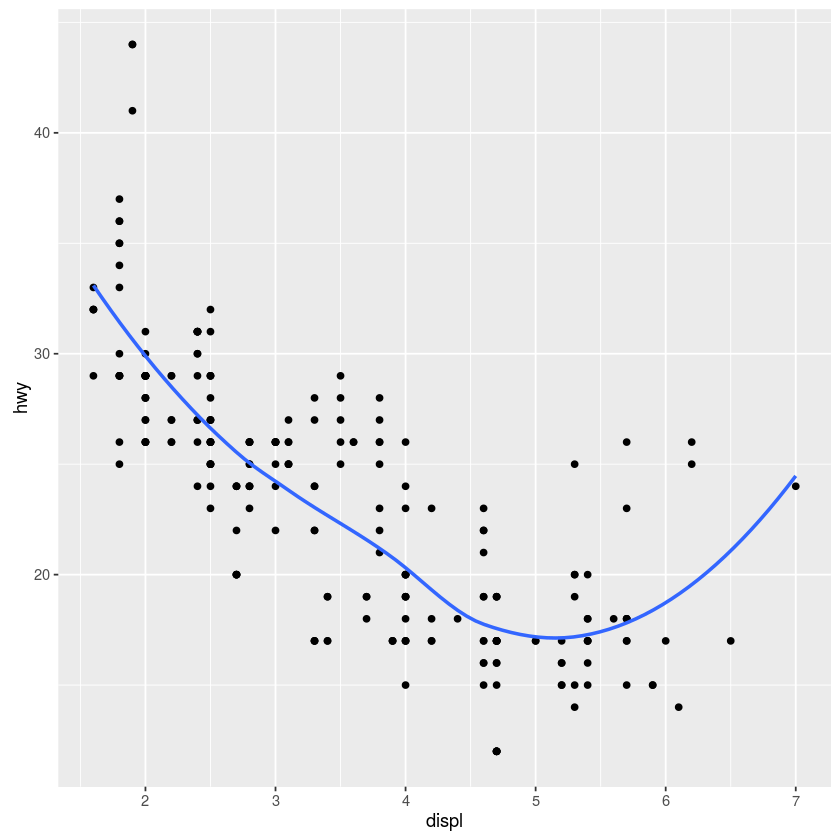

In [18]:
ggplot(mpg, aes(x = displ, y = hwy)) + geom_point() + geom_smooth(se = FALSE)

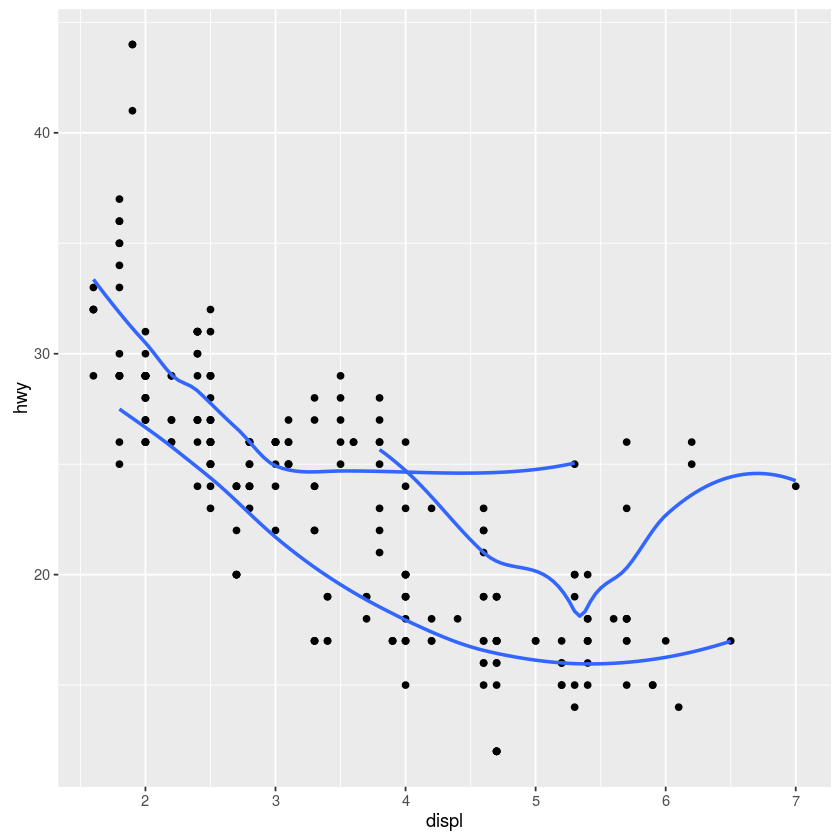

In [19]:
ggplot(mpg, aes(x = displ, y = hwy)) +
  geom_point() +
  geom_smooth(mapping = aes(group = drv), se = FALSE)

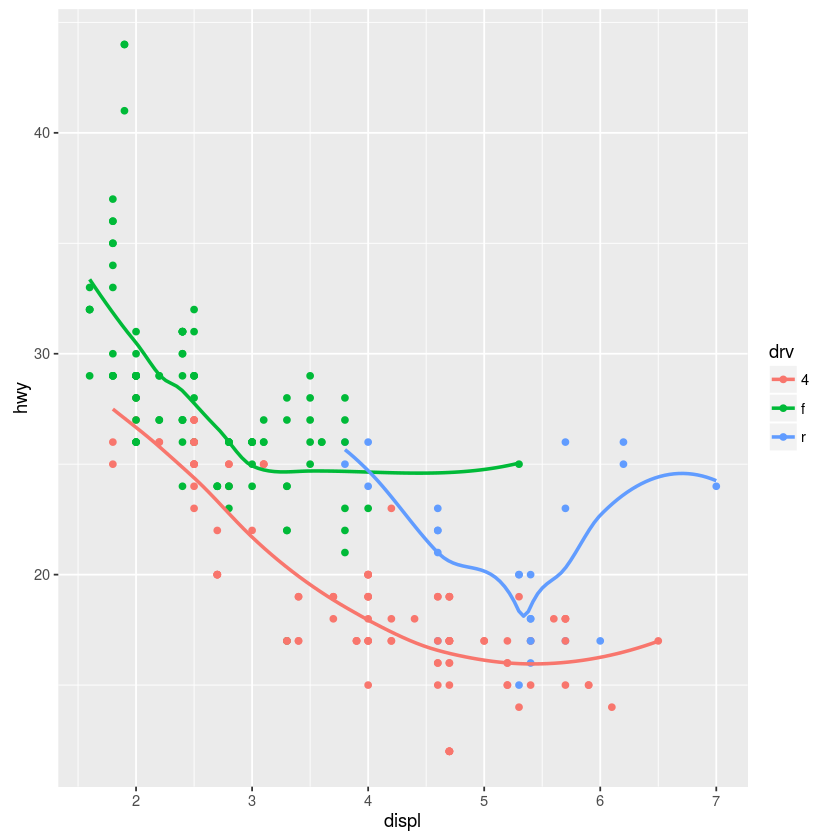

In [20]:
ggplot(mpg, aes(x = displ, y = hwy, colour = drv)) +
geom_point() +
geom_smooth(se = FALSE)

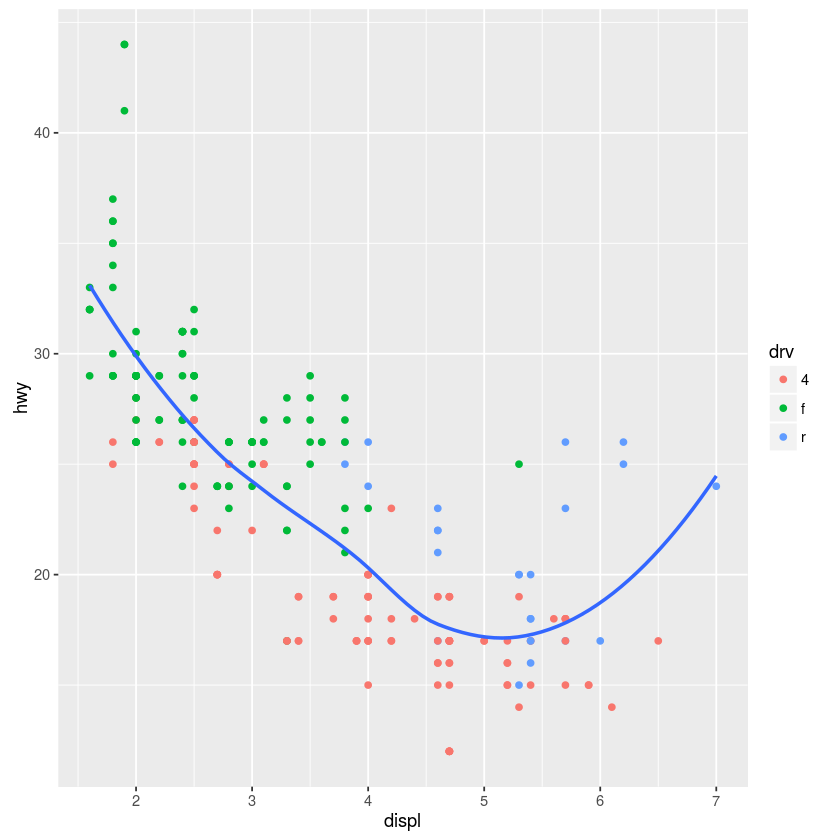

In [21]:
ggplot(mpg, aes(x = displ, y = hwy)) +geom_point(mapping = aes(colour = drv)) + geom_smooth(se = FALSE)

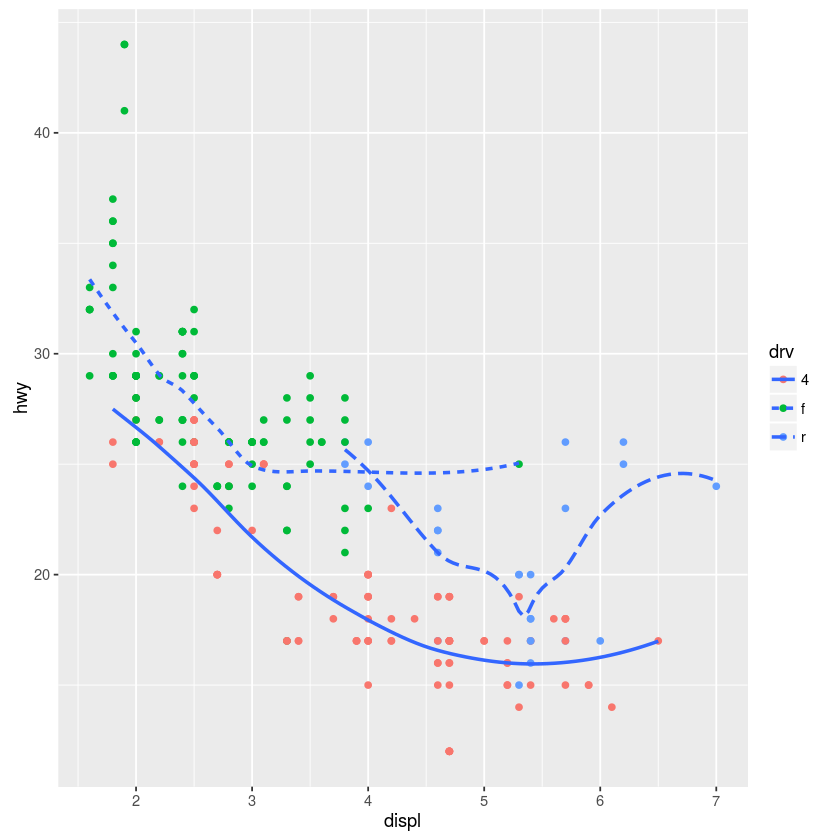

In [22]:
ggplot(mpg, aes(x = displ, y = hwy)) +
  geom_point(aes(colour = drv)) +
  geom_smooth(aes(linetype = drv), se = FALSE)

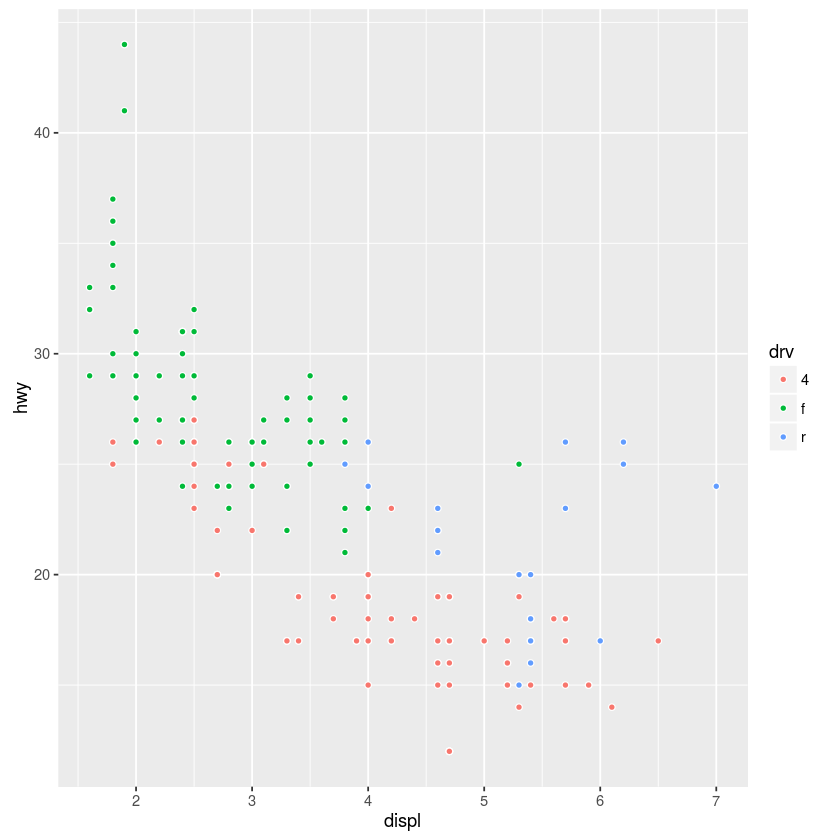

In [23]:
ggplot(mpg, aes(x = displ, y = hwy, fill = drv)) + geom_point(color = "white", shape = 21)

### Solución 5

In [24]:
lapply(iris[, sapply(iris, is.numeric)], function(x) {tapply(x, iris$Species, mean)})


$Sepal.Length
    setosa versicolor  virginica 
     5.006      5.936      6.588 

$Sepal.Width
    setosa versicolor  virginica 
     3.428      2.770      2.974 

$Petal.Length
    setosa versicolor  virginica 
     1.462      4.260      5.552 

$Petal.Width
    setosa versicolor  virginica 
     0.246      1.326      2.026

In [25]:
pidigits = read.table("http://www.itl.nist.gov/div898/strd/univ/data/PiDigits.dat", skip=60)
table(pidigits)

pidigits
  0   1   2   3   4   5   6   7   8   9 
466 531 496 461 508 525 513 488 491 521 

In [26]:
library("DAAG")

nombres <- c("tinting", "possum", "possumsites")
entorno <- as.environment("package:DAAG")
sapply(nombres, function(n) dim(entorno[[n]])[1] )

Loading required package: lattice

Attaching package: ‘DAAG’

The following object is masked from ‘package:MASS’:

    hills



tinting      possum possumsites 
        182         104           7

Respuesta al problema anterior, de otra forma:

In [27]:
# Usando la función dim()
dim(tinting)[1]
dim(possum)[1]
dim(possumsites)[1]

[1] 182

[1] 104

[1] 7

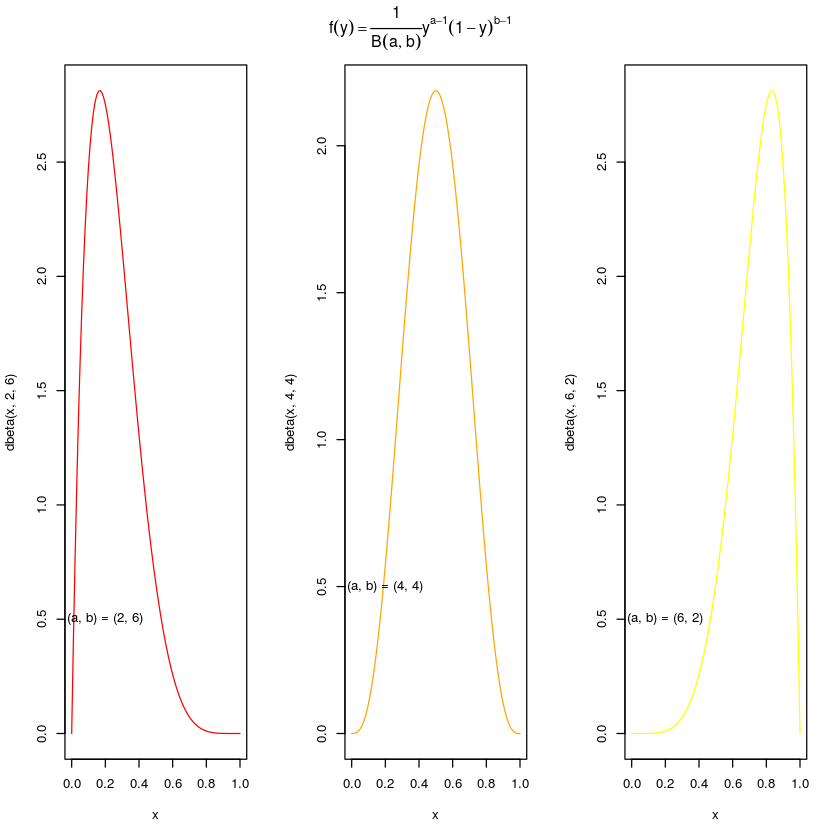

In [28]:
# Se puede dibujar un sola densidad beta, con paramétros a = 5 y b = 2, usando la función curve()

par(mfrow = c(1, 3)) # Usamos la funcion par() y dibujar los graficos 
curve(dbeta(x, 2, 6), from=0, to=1, col = "red")
text(x = 0.2, y = 0.5, labels = "(a, b) = (2, 6)")
curve(dbeta(x, 4, 4), from=0, to=1, col = "orange")
text(x = 0.2, y = 0.5, labels = "(a, b) = (4, 4)")
curve(dbeta(x, 6, 2), from=0, to=1, col = "yellow")
text(x = 0.2, y = 0.5, labels = "(a, b) = (6, 2)")

title(expression(f(y)==frac(1,B(a,b))*y^{a-1}*(1-y)^{b-1}), outer = T, line = -1.8)


In [29]:
# Función que calculan el i-ésimo momento central de un vector numérico

momento <- function(i) {
  function(x) sum((x - mean(x)) ^ i) / length(x)
}

m1 <- momento(1)
m2 <- momento(2)

x <- runif(100)
stopifnot(all.equal(m1(x), 0))
stopifnot(all.equal(m2(x), var(x) * 99 / 100))

In [30]:
# Integracion

#En lugar de crear funciones individuales (puntomedio(), trapecio(), simpson(), etc.), queremos
# almacenarlos en una lista. Una lista como esa podría hacerse escribiendo:

manual_newton_cotes_lista <- list(
    rectangulo = function(f, a, b) {
        (b - a) * f((a - b) / 2)
    },
  trapecio = function(f, a, b) {
      (b - a) / 2 * (f(a) + f(b))
  }
)

# Y las funciones en esa lista se podrían llamar como sigue:
manual_newton_cotes_lista$rectangulo(function(x) x^2, 0, 1) # 1/4

# Podemos crear la lista de funciones desde una lista de coeficients para la formula Newton-Cotes 
# Empezamos escribiendo la sguiente clausura :
    
newton_cotes_1 <- function(coefs){
  function(f, a, b) {
    pos <- function(i) a + i * (b - a) / (length(coefs) - 1)
    fi <- function(i) f(pos(i))
    (b - a)/ sum(coefs) * sum(coefs * fi(0:9)[1:length(coefs)])
  }
}

# Usamos la clausura para hacer una lista de funciones de Newton-Cotes :
newton_cotes_lista <- list(
  trapecio = newton_cotes_1(c(1, 1)),
  simpson = newton_cotes_1(c(1, 4, 1)),
  boole = newton_cotes_1(c(7, 32, 12, 32, 7))
)

newton_cotes_lista$trapecio(function(x) x^2, 0, 1) # 1/2
newton_cotes_lista$simpson(function(x) x^2, 0, 1) # 1/3
newton_cotes_lista$boole(function(x) x^2, 0, 1) # 1/3

[1] 0.25

[1] 0.5

[1] 0.3333333

[1] 0.3333333